In [1]:
from typing import Annotated, Literal, TypedDict
import tools
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


In [ ]:
import re
from typing import Annotated, List, Optional
import operator

from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough
from tools import prompt_tool

class Doc(TypedDict):
    id: str
    content: str
    # summary: Optional[str]
    explanation: Optional[str]
    # category: Optional[str]
class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomies (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]
    

json_schema = "{{summary: str, explanation: str}}"
summary_prompt = tools.parse_template([
    {
        "role": "system",
        "content": f"You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {json_schema}",
    },
    {
        "role": "human",
        "content": "{content}"
    }
])
summary_chain = tools.prompt_tool(
    tool_name="summarization",
    prompt_template=summary_prompt,
    model="gpt-4o-mini",
    api_key=open("../api_key").read(),
    format="json"
)

# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_content(state: TaxonomyGenerationState):
    docs = state["documents"]
    return [{"content": doc["content"]} for doc in docs]


map_step = RunnablePassthrough.assign(
    # This effectively creates a "map" operation # Note you can make this more robust by handling individual errors
    summaries=get_content | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)


def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }


# This is actually the node itself!
map_reduce_chain = map_step | reduce_summaries

In [16]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_edge(START, "summarize")

app = graph.compile()

import json
docs = json.load(open("docs.json"))
final_state = app.invoke(
    {"documents": docs},
    config={"configurable": {"thread_id": 42}},
)
print(final_state)


{'documents': [{'id': '0', 'content': 'Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n  - A freeze on petrol duty \n  - An extension of tax credit scheme for poorer families \n  - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifest

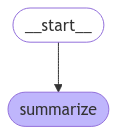

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from pprint import pprint
pprint(final_state)

{'clusters': [],
 'documents': [{'content': 'Budget to set scene for election\n'
                           ' \n'
                           ' Gordon Brown will seek to put the economy at the '
                           "centre of Labour's bid for a third term in power "
                           'when he delivers his ninth Budget at 1230 GMT. He '
                           'is expected to stress the importance of continued '
                           'economic stability, with low unemployment and '
                           'interest rates. The chancellor is expected to '
                           'freeze petrol duty and raise the stamp duty '
                           'threshold from Â£60,000. But the Conservatives and '
                           'Lib Dems insist voters face higher taxes and more '
                           'means-testing under Labour.\n'
                           ' \n'
                           ' Treasury officials have said there will not be a '
        

In [14]:
from langchain_core.prompts import ChatPromptTemplate
json_schema = "{{summary: str, explanation: str}}"
messages = [
    {
        "role": "system",
        "content": f"You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {json_schema}",
    },
    {
        "role": "human",
        "content": "{content}"
    }
]
summary_prompt = tools.parse_template(messages)
print(summary_prompt)
template = ChatPromptTemplate(summary_prompt)
template

[('system', 'You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {{summary: str, explanation: str}}'), ('human', '{content}')]


ChatPromptTemplate(input_variables=['content'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a summarization system. Please summarize the following text and give an explanation. Reply with the following JSON format: {{summary: str, explanation: str}}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['content'], input_types={}, partial_variables={}, template='{content}'), additional_kwargs={})])